In [66]:
# Final Project: Redistricing Project of Massachutes and Oregon. 
# Class: IE 5318 Principles of Operations Reasearch
# Team Members: Natalie Ventura, Jessica Dedeaux, Damilola Fasheru
# Date: Fall 2023; 12-12-2023

# GitHub Project file: https://github.com/Jdedeaux/Districts-Counties/tree/main
# Credit to: 
#     Dr. Hamidreza Validi transportation, short path codes, and assigment codes: IE 5318 Principles of Operations Reasearch at Texas Tech University
#     Dr. Austin Buchanan districting example starter code: https://github.com/AustinLBuchanan/Districting-Examples/tree/main
#     Gurobi Optimization Tutorial via the primary website: https://www.gurobi.com/resources/lp-chapter-6-modeling-and-solving-linear-programming-problems/
#      https://www.youtube.com/watch?v=xxg4Vm-Xg9g

In [67]:
# Install before. For GEOPANDAS and envioronment will need to be created within Jupyter Notebook.
# pip install gerrychain
# conda install geopandas using the terminal
# pip install geopandas

In [68]:
# MASSACHUSETTS

In [69]:
# Import the following packages to run various cells
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import geopandas as gpd
import math
import pandas as pd
import matplotlib.pyplot as plt

<class 'networkx.classes.graph.Graph'>
The Massachusetts graph has 14 nodes
The Massachusetts graph has 24 edges
Massachusetts graph has nodes [0, 5, 13, 1, 2, 7, 12, 6, 3, 4, 11, 10, 9, 8]
Massachusetts graph has edges [(0, 5), (0, 13), (5, 1), (5, 2), (5, 13), (13, 1), (13, 7), (1, 2), (1, 7), (1, 12), (2, 6), (2, 12), (7, 3), (7, 4), (7, 10), (12, 6), (12, 9), (6, 9), (3, 4), (3, 11), (4, 10), (4, 11), (11, 10), (9, 8)]


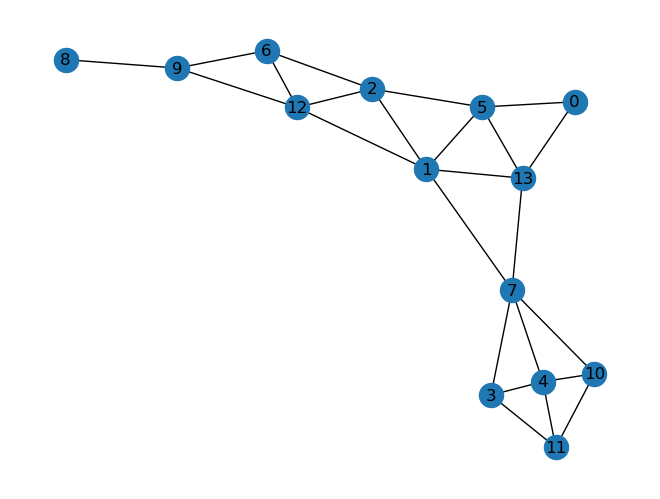

In [70]:
# Step 1: Define the edges and nodes
# Create the intial node and edges model using the edges list for Maine
# Remove the non-integers from the text file and ensure it is a plain text file.
filepath = '/Users/jessi/Gurobi-Python Playground/MA.dimacs-mod.txt'

####################
# If using the unmodified .dimacs file, it will need to be manipulated to only utilize integers. Removing column 1, row 1, last row
# filepath = "/Users/jessi/Gurobi-Python Playground/MA.dimacs"
# file = open(filepath)

# #remove the header and tail to over mixing int and str
# next(file)
# last_line = None
# for line in file:
#     if last_line:
#         for line in file:
#             if line.strip():
#                 file.write("\t".join(line.split()[1:]) + "\n")
#         print (last_line)
#         last_line = line
# # for line in file:
# #         try:
# #             r = int(line)
# #             if r > 999 or line.strip() == '-0':
# #                 #filtering numbers >999 and strings with '-0' 
# #                 continue 
# #             file.append(r)
# #         except ValueError:
# #             pass

# # Create List of integers
# # nodes_edges = []
# # for each in file:
# #     each = each.strip()
# #     #split the list so the populations in each range
# #     each = each.split(' ')
# #     print((each[1], each[2]))
# #     nodes_edges.append(int(each[1], each[2]))
#####################

# reading from the data set
G = nx.read_edgelist(filepath,nodetype=int)

print(type(G))

# drawing the graph
nx.draw(G, with_labels=True)

# Current model description
print("The Massachusetts graph has",G.number_of_nodes(),"nodes")
print("The Massachusetts graph has",G.number_of_edges(),"edges")
print("Massachusetts graph has nodes",G.nodes )
print("Massachusetts graph has edges",G.edges )

In [71]:
# Step 2: List the county populations
# Integrate the populations by county to the model
import gurobipy as gp
from gurobipy import GRB

#shifts = range(1,9000000)

# create population list
population = list()

# read text file into software system using files on local drive
filepath = "/Users/jessi/Gurobi-Python Playground/MA.population"
file = open( filepath,"r")

#remove the header to over mixing int and str
next(file)

#Create List
Listpop = []
for each in file:
    #split the list so the populations in each range
    each = each.split(' ')
    #print((each[1])
    Listpop.append(int(each[1]))
#displays the list of integers  
print("Massachusetts's county populations = ", Listpop)

#since the list is sorted, the sums can be taken by list position
total_population = sum(Listpop)

#print the total population of MA
print("The total_population of Massachusetts = ", total_population)
population = Listpop
n =len(population)

#print the county population as a sum districts of MA
print("Massachusetts's number of districts = ",n)

Massachusetts's county populations =  [809829, 725981, 530819, 71029, 162308, 797936, 228996, 862111, 14255, 20600, 465825, 129026, 579200, 1632002]
The total_population of Massachusetts =  7029917
Massachusetts's number of districts =  14


In [72]:
# Build the model to show which counties will be in which district
# If model is feasible, 
# create model 
m = gp.Model()

# Impose a 1% population deviation (+/- 0.5%) for the Operations Research model
deviation = 0.01
k =9

# Lower and Upper bound populations to ensure the populations of the districts do not exceed the bounds
L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)

# create variables
x = m.addVars(n,k,vtype=GRB.BINARY) # x_ij equals one when county i is assigned to district j
y = m.addVar()                      # the population of least-populated district
z = m.addVar()                      # the population of most-populated district

# objective is to minimize absolute population deviation
m.setObjective(z-y,GRB.MINIMIZE)

# add constraints saying that each county i is assigned to one district
m.addConstrs(sum(x[i,j] for j in range(k)) == 1 for i in range(n))

# add constraints saying that each district has population at least y
m.addConstrs(y <= sum(population[i] * x[i,j] for i in range(n)) for j in range(k))

# add constraints saying that each district has population at most z
m.addConstrs(sum( population[i] * x[i,j] for i in range(n)) <= z for j in range(k))

# solve IP model
m.optimize()

# Match the districs to the populations per the sum of the county populations
districts = [[i for i in range(n) if x[i,j].x > 0.5] for j in range(k)]
district_populations = [sum(population[i] for i in district) for district in districts]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 32 rows, 128 columns and 396 nonzeros
Model fingerprint: 0xdfc0e59d
Variable types: 2 continuous, 126 integer (126 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3330120.0000
Presolve time: 0.00s
Presolved: 32 rows, 128 columns, 396 nonzeros
Variable types: 0 continuous, 128 integer (126 binary)

Root relaxation: objective 0.000000e+00, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   15 3330120.00    0.00000   100%     -    0s
H    0     0                    2753765.0000    0

In [73]:
# Current model status 

# print the absolute population deviation
print("The absolute population deviation is",m.objval,"person(s).")

print("Using Lower Bound of Population =",L,"and Upper Bound of Population =",U,"and districs =",k)

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",districts[j])
    
# print the optimal minization of cut edges
print("The number of cut edges is",m.objval)

The absolute population deviation is 1095148.0 person(s).
Using Lower Bound of Population = 777197 and Upper Bound of Population = 785007 and districs = 9
District 0 has population 1632002 and contains counties [13]
District 1 has population 579200 and contains counties [12]
District 2 has population 536854 and contains counties [3, 10]
District 3 has population 540930 and contains counties [4, 6, 9, 11]
District 4 has population 725981 and contains counties [1]
District 5 has population 862111 and contains counties [7]
District 6 has population 809829 and contains counties [0]
District 7 has population 797936 and contains counties [5]
District 8 has population 545074 and contains counties [2, 8]
The number of cut edges is 1095148.0


<class 'networkx.classes.graph.Graph'>


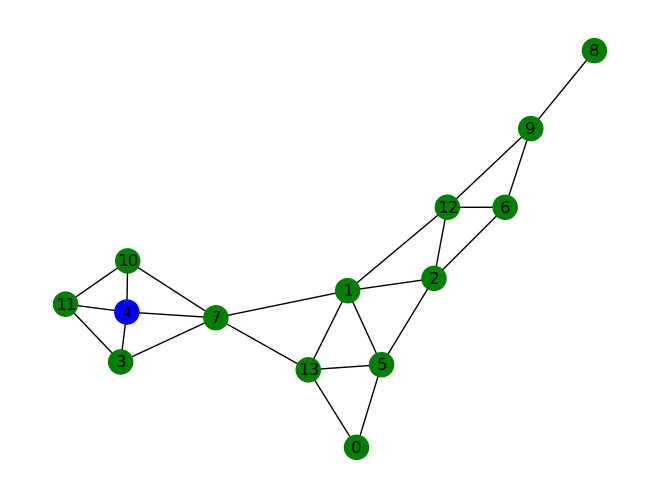

In [74]:
## HELP ##
filepath = '/Users/jessi/Gurobi-Python Playground/MA.dimacs-mod.txt'
G = nx.read_edgelist(filepath,nodetype=int)

print(type(G))

# Nodes to districts?
color_map = []
for node in G:
    if node == 4:
        color_map.append('blue')
    else: 
        color_map.append('green')
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

                                             geometry
0   POLYGON ((-71.18240 42.79433, -71.18237 42.794...
1   MULTIPOLYGON (((-71.33850 42.21523, -71.33840 ...
2   POLYGON ((-71.06959 42.04970, -71.06961 42.049...
3   POLYGON ((-72.95460 42.62865, -72.95104 42.641...
4   POLYGON ((-72.99264 42.44909, -72.99250 42.449...
5   POLYGON ((-71.03318 42.41421, -71.03301 42.414...
6   POLYGON ((-70.66800 41.51199, -70.66952 41.513...
7   POLYGON ((-72.21397 42.29426, -72.21425 42.294...
8   POLYGON ((-70.49331 41.27998, -70.43684 41.299...
9   POLYGON ((-70.89620 41.37008, -70.90260 41.367...
10  POLYGON ((-73.03492 42.14365, -73.03492 42.143...
11  POLYGON ((-73.41085 42.35175, -73.40932 42.355...
12  POLYGON ((-71.33879 41.89859, -71.33904 41.898...
13  POLYGON ((-71.54339 42.46645, -71.54411 42.466...
<class 'geopandas.geodataframe.GeoDataFrame'>


(-73.69067745, -69.67639354999999, 41.10206675, 42.97176425)

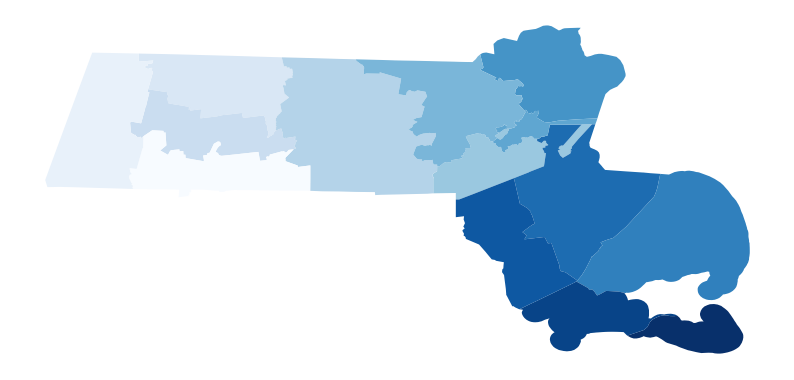

In [75]:
# Modeling the nodes and edges model into shape of Massachutes

# Read Massachutes county shapefile and distance files
file1 = '/Users/jessi/Gurobi-Python Playground/MA_distances.csv'
file2 = '/Users/jessi/Gurobi-Python Playground/MA_counties.shx'
file = '/Users/jessi/Gurobi-Python Playground/MA_counties.shp'
df = gpd.read_file(file)

print((df))
print(type(df))


fig,ax = plt.subplots(figsize=(10,10))
df.plot(ax=ax, column = "geometry", cmap ='Blues')
ax.axis("off")

In [76]:
## HELP ##
df = gpd.read_file(file)

print((df))
print(type(df))

print ("counties", G.nodes)
print ("county lines", G.edges)
print (districts)

# Assigning the counties to districts?
counties = G.nodes

districts = districts
print("counties", counties)
print("districts", districts)
print(districts[0])

# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    # for each node i in this district
    for i in districts[j]:
        

#Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
Massachusetts = df.plot(column='assignment').get_figure()

IndentationError: expected an indented block after 'for' statement on line 25 (1568704545.py, line 29)

In [77]:
# OREGON

<class 'networkx.classes.graph.Graph'>
The Oregon graph has 36 nodes
The Oregon graph has 81 edges
Oregon graph has nodes [0, 14, 18, 22, 1, 8, 17, 2, 6, 16, 26, 29, 31, 3, 7, 24, 32, 33, 4, 11, 21, 35, 5, 9, 20, 30, 13, 19, 28, 10, 25, 27, 12, 15, 34, 23]
Oregon graph has edges [(0, 14), (0, 18), (0, 22), (14, 10), (14, 17), (14, 22), (14, 32), (18, 32), (22, 1), (22, 17), (1, 8), (1, 17), (8, 5), (8, 9), (8, 13), (8, 17), (8, 25), (8, 30), (17, 10), (17, 25), (2, 6), (2, 16), (2, 26), (2, 29), (2, 31), (6, 13), (6, 16), (6, 19), (6, 28), (6, 29), (6, 33), (16, 13), (16, 26), (16, 30), (26, 12), (26, 20), (26, 23), (26, 30), (26, 31), (26, 34), (29, 19), (31, 23), (3, 7), (3, 24), (3, 32), (3, 33), (7, 10), (7, 24), (7, 25), (7, 28), (7, 32), (24, 28), (24, 33), (32, 10), (33, 19), (33, 28), (33, 35), (4, 11), (4, 21), (4, 35), (11, 27), (11, 35), (21, 19), (21, 35), (35, 19), (35, 27), (5, 9), (5, 20), (5, 30), (20, 12), (20, 30), (30, 13), (13, 25), (13, 28), (28, 25), (10, 25), (12

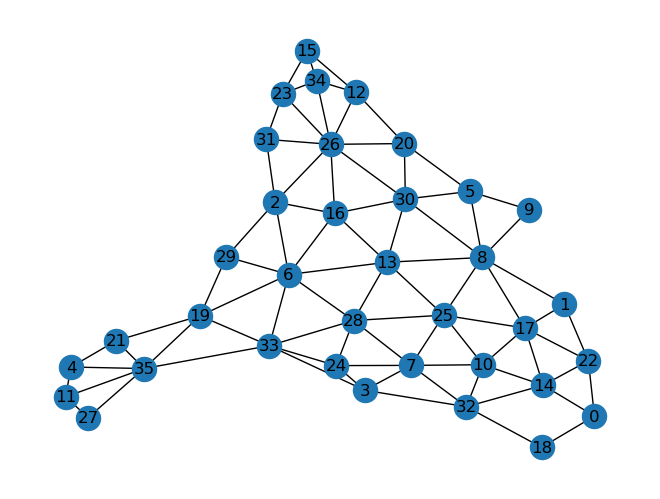

In [78]:
# Step 1: Define the edges and nodes
# Create the intial node and edges model using the edges list for Maine
# Remove the non-integers from the text file and ensure it is a plain text file.
filepath = '/Users/jessi/Gurobi-Python Playground/OR.dimacs-mod.txt'

####################
# If using the unmodified .dimacs file, it will need to be manipulated to only utilize integers. Removing column 1, row 1, last row
# filepath = "/Users/jessi/Gurobi-Python Playground/MA.dimacs"
# file = open(filepath)

# #remove the header and tail to over mixing int and str
# next(file)
# last_line = None
# for line in file:
#     if last_line:
#         for line in file:
#             if line.strip():
#                 file.write("\t".join(line.split()[1:]) + "\n")
#         print (last_line)
#         last_line = line
# # for line in file:
# #         try:
# #             r = int(line)
# #             if r > 999 or line.strip() == '-0':
# #                 #filtering numbers >999 and strings with '-0' 
# #                 continue 
# #             file.append(r)
# #         except ValueError:
# #             pass

# # Create List of integers
# # nodes_edges = []
# # for each in file:
# #     each = each.strip()
# #     #split the list so the populations in each range
# #     each = each.split(' ')
# #     print((each[1], each[2]))
# #     nodes_edges.append(int(each[1], each[2]))
#####################

# reading from the data set
G = nx.read_edgelist(filepath,nodetype=int)

print(type(G))

# drawing the graph
nx.draw(G, with_labels=True)

# Current model description
print("The Oregon graph has",G.number_of_nodes(),"nodes")
print("The Oregon graph has",G.number_of_edges(),"edges")
print("Oregon graph has nodes",G.nodes )
print("Oregon graph has edges",G.edges )

In [79]:
# Step 2: List the county populations
# Integrate the populations by county to the model
import gurobipy as gp
from gurobipy import GRB

#shifts = range(1,9000000)

# create population list
population = list()

# read text file into software system using files on local drive
filepath = "/Users/jessi/Gurobi-Python Playground/OR.population"
file = open( filepath,"r")

#remove the header to over mixing int and str
next(file)

#Create List
Listpop = []
for each in file:
    #split the list so the populations in each range
    each = each.split(' ')
    #print((each[1])
    Listpop.append(int(each[1]))
#displays the list of integers  
print("Oregon's county populations = ", Listpop)

#since the list is sorted, the sums can be taken by list position
total_population = sum(Listpop)

#print the total population of MA
print("The total_population of Oregon = ", total_population)
population = Listpop
n =len(population)

#print the county population as a sum districts of MA
print("Oregon's number of districts = ",n)

Oregon's county populations =  [52589, 23977, 7495, 50395, 88090, 1995, 198253, 87433, 26670, 1870, 107722, 23446, 80075, 24502, 600372, 7391, 24738, 421401, 41072, 69413, 12186, 223259, 815428, 16668, 95184, 345920, 7233, 64929, 128610, 8160, 1451, 31571, 27390, 382971, 26196, 111201]
The total_population of Oregon =  4237256
Oregon's number of districts =  36


In [80]:
# Build the model to show which counties will be in which district
# If model is feasible, 
# create model 
m = gp.Model()

# Impose a 1% population deviation (+/- 0.5%) for the Operations Research model
deviation = 0.01
k =6

# Lower and Upper bound populations to ensure the populations of the districts do not exceed the bounds
L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)

# create variables
x = m.addVars(n,k,vtype=GRB.BINARY) # x_ij equals one when county i is assigned to district j
y = m.addVar()                      # the population of least-populated district
z = m.addVar()                      # the population of most-populated district

# objective is to minimize absolute population deviation
m.setObjective(z-y,GRB.MINIMIZE)

# add constraints saying that each county i is assigned to one district
m.addConstrs(sum(x[i,j] for j in range(k)) == 1 for i in range(n))

# add constraints saying that each district has population at least y
m.addConstrs(y <= sum(population[i] * x[i,j] for i in range(n)) for j in range(k))

# add constraints saying that each district has population at most z
m.addConstrs(sum( population[i] * x[i,j] for i in range(n)) <= z for j in range(k))

# solve IP model
m.optimize()

# Match the districts to the populations per the sum of the county populations
districts = [[i for i in range(n) if x[i,j].x > 0.5] for j in range(k)]
district_populations = [sum(population[i] for i in district) for district in districts]

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 48 rows, 218 columns and 660 nonzeros
Model fingerprint: 0x00001389
Variable types: 2 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 957825.00000
Presolve time: 0.00s
Presolved: 48 rows, 218 columns, 660 nonzeros
Variable types: 0 continuous, 218 integer (216 binary)

Root relaxation: objective 0.000000e+00, 52 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    9 957825.000    0.00000   100%     -    0s
H    0     0                    611097.00000    0

In [81]:
# Current model status 

# print the absolute population deviation
print("The absolute population deviation is",m.objval,"person(s).")

print("Using Lower Bound of Population =",L,"and Upper Bound of Population =",U,"and districts =",k)

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",districts[j])
    
# print the optimal minization of cut edges
print("The number of cut edges is",m.objval)

The absolute population deviation is 131069.0 person(s).
Using Lower Bound of Population = 702679 and Upper Bound of Population = 709740 and districts = 6
District 0 has population 684367 and contains counties [0, 7, 16, 19, 20, 30, 32, 33, 34]
District 1 has population 815428 and contains counties [22]
District 2 has population 684372 and contains counties [3, 9, 13, 14, 26]
District 3 has population 684362 and contains counties [11, 12, 17, 23, 31, 35]
District 4 has population 684359 and contains counties [2, 8, 15, 24, 25, 27, 28, 29]
District 5 has population 684368 and contains counties [1, 4, 5, 6, 10, 18, 21]
The number of cut edges is 131069.0


                                             geometry
0   POLYGON ((-123.35949 46.01121, -123.35959 46.0...
1   POLYGON ((-121.63812 45.70477, -121.63132 45.7...
2   POLYGON ((-119.89506 43.56813, -119.89506 43.5...
3   POLYGON ((-124.14651 44.77862, -124.14609 44.7...
4   POLYGON ((-124.00393 42.45154, -124.00387 42.4...
5   POLYGON ((-120.36083 45.50569, -120.36080 45.5...
6   POLYGON ((-121.40550 44.39315, -121.40256 44.3...
7   POLYGON ((-123.72466 44.98427, -123.72462 44.9...
8   POLYGON ((-121.71160 45.15282, -121.71222 45.1...
9   POLYGON ((-120.82708 45.51531, -120.82814 45.5...
10  POLYGON ((-123.46310 45.28019, -123.46310 45.2...
11  POLYGON ((-124.54413 42.68382, -124.55310 42.6...
12  POLYGON ((-119.14139 45.93100, -119.13504 45.9...
13  POLYGON ((-121.14964 44.39065, -121.15085 44.3...
14  POLYGON ((-123.20927 45.43371, -123.20976 45.4...
15  POLYGON ((-117.74746 45.83324, -117.74745 45.8...
16  POLYGON ((-121.01452 44.39032, -121.01311 44.3...
17  POLYGON ((-122.74374 45.

(-125.11555495, -116.05124805, 41.776731149999996, 46.51444985)

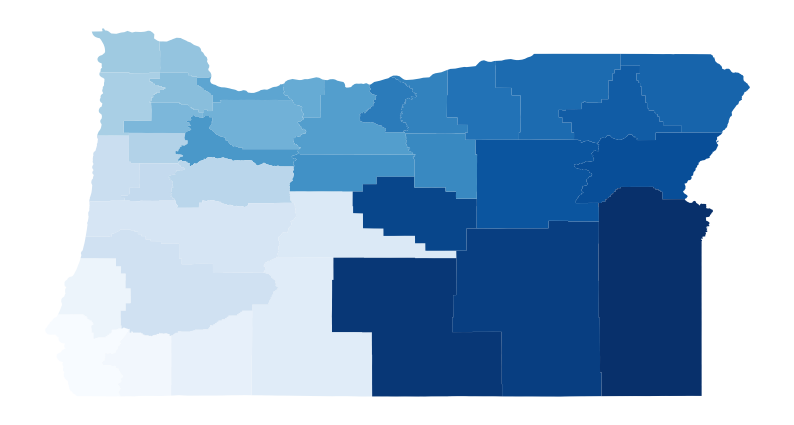

In [82]:
# Modeling the node and edges model into shape of Maine
import geopandas as gpd

# Read Maine county shapefile and distance files
file1 = '/Users/jessi/Gurobi-Python Playground/OR_distances.csv'
file2 = '/Users/jessi/Gurobi-Python Playground/OR_counties.shx'
file = '/Users/jessi/Gurobi-Python Playground/OR_counties.shp'
df = gpd.read_file(file)

print((df))
print(type(df))


fig,ax = plt.subplots(figsize=(10,10))
df.plot(ax=ax, column = "geometry", cmap ='Blues')
ax.axis("off")